# SAMPLING THE POSTERIOR USING MCMC

In [1]:
#!pip install tqdm
#!pip install galpy
#!pip install --upgrade numpy

In [2]:
import numpy as np 
import matplotlib.pyplot as plt

import scipy as sp

from astropy import constants, units

import tqdm
from multiprocessing import Pool

import corner

import emcee
import pandas as pd

import pickle

import dynesty

import matplotlib.image as mpimg

### Define global constants

In [3]:
r_sun = 8.34*units.kpc
v_sun = 239.89*units.km/units.s
G = constants.G

# Read in data

In [4]:
huang_data = pd.read_csv('./Huang data.csv',
                   delimiter=',',skiprows=1,names=["r","v","v_err","type"])

/tmp/ipykernel_889/3813236114.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap("inferno")


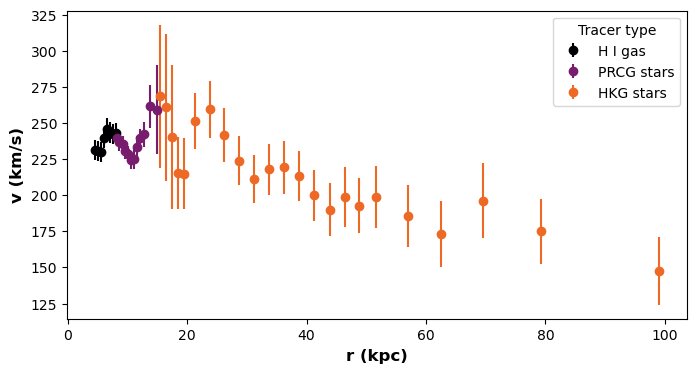

In [5]:
colormap = plt.cm.get_cmap("inferno")  
unique_types = huang_data["type"].unique()  
# Mapping each type to a color
colors = {t: colormap(i / len(unique_types)) for i, t in enumerate(unique_types)}  

type_title = ["H I gas","PRCG stars","HKG stars"]
plt.figure(figsize=(8,4))

# Plot each type with its corresponding color
for index,t in enumerate(unique_types):
    subset = huang_data[huang_data["type"] == t]
    plt.errorbar(
        subset["r"], subset["v"], yerr=subset["v_err"], 
        fmt="o", color=colors[t], label=f"{type_title[index]}"
    )

# Add labels, legend, and show the plot
plt.xlabel("r (kpc)",fontweight="bold",fontsize="large")
plt.ylabel(r"v (km/s)",fontweight="bold",fontsize="large")
plt.legend(title="Tracer type")

## Defining the stellar bulge matter distribution and circular velocity

According to Sofue (https://ned.ipac.caltech.edu/level5/Sept16/Sofue/Sofue4.html), since it was shown that the de Vaucouleurs law fails to fit the observed central rotation, another model has been proposed, called the exponential sphere model. In this model, the volume mass density ρ is represented by an exponential function of radius r with a scale radius a as 

$$
\rho(r) = \rho_c e^{-r/a} \tag{51}
$$

The mass involved within radius $r$ is given by
$$
M(R) = M_0 F(x), \tag{52}
$$
where $x = r/a$ and
$$
F(x) = 1 - e^{-x}(1 + x + x^2/2). \tag{53}
$$

The total mass is given by
$$
M_0 = \int_0^\infty 4\pi r^2 \rho dr = 8 \pi a^3 \rho_c. \tag{54}
$$

The circular rotation velocity is then calculated by
$$
V(r) = \sqrt{\frac{GM}{r}} = \sqrt{\frac{GM_0}{a} F\left(\frac{r}{a}\right)}. \tag{55}
$$

In this model, the rotational velocity has a narrower peak near the characteristic radius in a logarithmic plot as shown in figure 26. Note that the exponential-sphere model is nearly identical to that for the Plummer’s law, and the rotation curves have almost identical profiles. 

According to Sofue: "In this context, the Plummer law can be used to fit the central bulge components in place of the present models""

The overall bulge model is given by the superposition of an inner and outer bulge, each with total mass $M_{b,inner}$ and $M_{b,outer}$

Text(0, 0.5, 'v (km/s)')

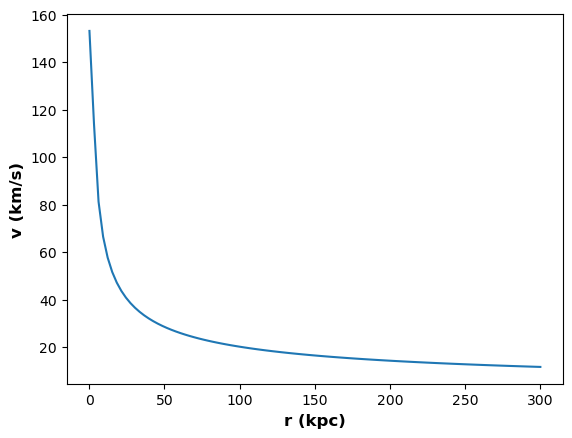

In [6]:
def stellar_bulge_velocity(r, M_b_inner,M_b_outer,
                           scale_radius_inner=0.0035,scale_radius_outer=0.120,
                          G=G.to(units.kpc**3 / units.M_sun / units.s**2).value):
    """
    Compute the circular velocity of a stellar bulge with a Plummer profile.

    Parameters
    ----------
    r : float or array_like
        Galactocentric distances in kpc.
    M_b_inner : float
        Total mass of the inner bulge in solar masses.
    scale_radius_inner : float, optional. Default: 0.0035 from Sofue paper (2016)
        Inner Bulge scale radius in kpc.
    M_b_outer : float
        Total mass of the outer bulge in solar masses.
    scale_radius_inner : float, optional. Default: 0.120 from Sofue paper (2016)
        Outer Bulge scale radius in kpc.
        

    Returns
    -------
    velocities : float or array_like
        Circular velocities in km/s.
    """ 
    
    def f(z):
        return 1 - np.exp(-z)*(1+z+(z)**2/2)
    
    x = r/scale_radius_inner
    y = r/scale_radius_outer

    term1 = (G*M_b_inner*f(x))/(scale_radius_inner*x)

    term2 = (G*M_b_outer*f(y))/(scale_radius_outer*y)
    
    velocities = np.sqrt(term1 + term2)*units.kpc/units.s
    
    return velocities.to(units.km/units.s).value

#quick plot to check
r = np.linspace(0.1,300,100)
v_b = stellar_bulge_velocity(r,5.4e7,9.4e9)
plt.plot(r,v_b)
plt.xlabel("r (kpc)",fontweight="bold",fontsize="large")
plt.ylabel("v (km/s)",fontweight="bold",fontsize="large")

## Defining the stellar disk velocity

The following is from Sofue (2020). Can also be found from (Sofue 2016, doi: 10.1093/pasj/xxx000, pg 24):

The galactic disk is represented by an exponential disk (Freeman 1970), where the surface mass density is expressed as

$$\Sigma_d(R) = \Sigma_{dc}(R)exp(\frac{-R}{R_d})$$

Where $\Sigma_{dc}$ is the central value and $R_d$ is the scale radius. The rotation curve for such a thin exponential disk is expressed by (Binney and Tremaine 1987):

$$V_{d(R)}^2 = 4\pi G \Sigma_0 R_dy^2[I_0(y)K_0(y) - I_1(y)K_1(y)]$$

where y = R/2Rd and I and K are the modified Bessel functions.

The total mass of the disk (the nuisance parameter) is given by $M_{dc} = 2\pi \Sigma_{dc}R_d^2 $

Text(0, 0.5, 'v (km/s)')

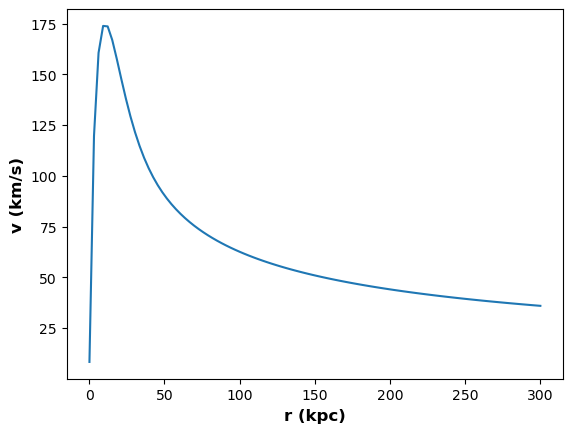

In [7]:
#This works. Free parameter here would be the total disk surface mass density. 
#We can also set R_d to be a free parameter, but I think scale length is well known generally
def stellar_disk_velocity(r,M_dc,R_d=4.9,G=G.to(units.kpc**3/(units.s**2*units.M_sun))):
    """
    Compute the circular velocity of a stellar disk with an exponential profile.

    Parameters
    ----------
    r : float or array_like
        Galactocentric distances in kpc.
    M_dc : float
        Total mass of the disk in solar masses.
    R_d : float, optional. Default: 4.9 kpc from Sofue paper (2016)
        Disk scale length in kpc.
    G : float, optional. Default units: 4.30091e-06 kpc^3/Gyr^2/M_sun

    Returns
    -------
    velocities : float or array_like
        Circular velocities in km/s.

    """
    r = r * units.kpc
    M_dc = M_dc * units.M_sun
    R_d = R_d * units.kpc
    sigma_dc = M_dc/(2*np.pi*R_d**2)
    y = r/(2*R_d)
    bessel = sp.special.i0(y)*sp.special.k0(y) - sp.special.i1(y)*sp.special.k1(y)  
    velocities = (4*np.pi*G*sigma_dc*R_d*(y**2)*bessel)**0.5
    return velocities.to(units.km/units.s).value

#quick plot to check
v_d = stellar_disk_velocity(r,0.9e11)
plt.plot(r,v_d)
plt.xlabel("r (kpc)",fontweight="bold",fontsize="large")
plt.ylabel("v (km/s)",fontweight="bold",fontsize="large")

## Defining the dark matter density and circular velocity

The dark matter distribution within the Galaxy can be found using a spherical Navarro, Frenk, and White (NFW) profile:

$$
\rho_{\text{NFW}}(r) = \rho_0 \left( \frac{R_0}{r} \right) \left( \frac{r_s + R_0}{r_s + r} \right)^{2}
$$

where:

- $\rho_0$: The dark matter density at the Sun's location, $R_0$.
- $R_0$: The radius of the Sun's location from the Galactic center $R_0 = 8.34 \, \text{kpc} $.
- $r_s$: The characteristic radius of the dark matter halo.

### Enclosed Mass

The enclosed mass within a sphere of radius R is:

$$
M_{\text{DM}}(<r) = 4\pi \int_0^r \rho_{\text{NFW}}(r) \, R^2 \, dR
$$

### Angular Velocity

For a circular orbit, the angular velocity due to the dark matter halo is:

$$
v_{\text{DM}}^2(r) = \frac{G M_{\text{DM}}(<r)}{r}
$$

where G is the gravitational constant.

Text(0, 0.5, 'v (km/s)')

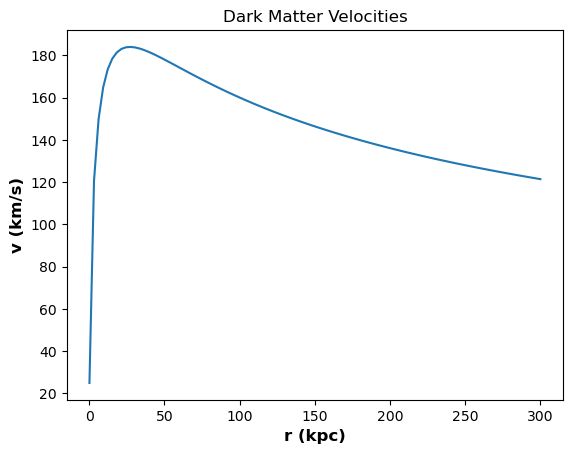

In [8]:
def dm_velocity(r,rho_0,r_s,R_0=r_sun.value,
            G=G.to(units.kpc**3 /units.M_sun/units.s**2).value):
    """"
    Compute the density profile of a dark matter halo with a GNFW profile.

    Parameters
    ----------
    r : float or array_like
        Galactocentric distance values in kpc.
    rho_0 : float
        Central density value in GeV/cm³.
    r_s : float
        Scale radius value in kpc.
    R_0 : float, optional. Default: 8.34 kpc
        Solar galactocentric distance value in kpc.

    Returns
    -------
    density : float or array_like
        Density profile value in kg/kpc³.
    """
    
    rho_0 = rho_0 * (0.0075/0.3) *units.M_sun / units.pc**3
    rho_0 = rho_0.to(units.M_sun/units.kpc**3).value
    mass_integral = 4*np.pi*rho_0*R_0*(r_s+R_0)**2*(np.log(r_s+r) - np.log(r_s) + (r_s/(r_s+r)) - 1)
    
    velocities = np.sqrt(G*mass_integral/r)*units.kpc/units.s

    return velocities.to(units.km/units.s).value

#quick plot to check
rho_0 = 0.4
r_s = 12.5

v_dm = dm_velocity(r, rho_0, r_s,)

plt.plot(r, v_dm)
plt.title('Dark Matter Velocities')
plt.xlabel("r (kpc)",fontweight="bold",fontsize="large")
plt.ylabel("v (km/s)",fontweight="bold",fontsize="large")

## GLOBAL MODEL OF THE GALAXY

Fit a global model of the Galaxy that consists of three components: stellar disk, stellar bulge and dark matter halo,

$$
v_c^2(\Theta, M_{dc}, M_b) = v_{\text{disk}}^2(M_{dc}) + v_{\text{bulge}}^2(M_b) + v_{\text{DM}}^2(\Theta),
$$

where $ \Theta = (\rho_0, r_s)$ and $M_b = (M_{b,inner}, M_{b,outer})$. Note that each term in this eq. is implicitly a function of galactocentric radius $ r $ 

Text(0, 0.5, 'v (km/s)')

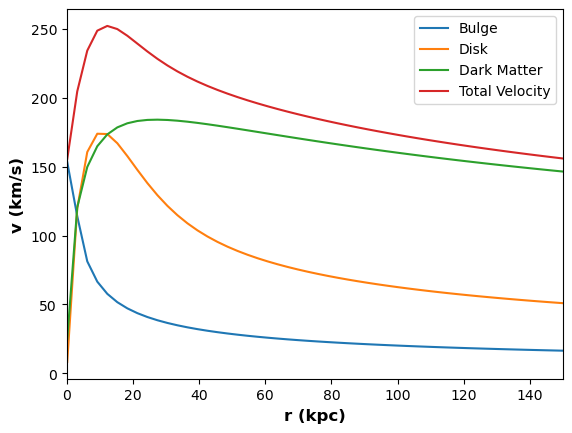

In [9]:
def omega_c(r, r_s, rho_0, M_b_inner,M_b_outer, M_dc):  
    """
    Compute the velocity of the Milky Way rotation curve.

    Parameters
    ----------
    r : float or array_like
        Galactocentric distance values in kpc.
    r_s : float
        Scale radius of the dark matter halo, value in kpc.
    gamma : float
        Inner slope of the dark matter halo.
    rho_0 : float
        Central density of the dark matter halo, value in GeV/cm³.
    M_b : float
        Total mass of the bulge in solar masses.
    M_dc : float
        Total mass of the disk in solar masses.

    Returns
    -------
    velocities : float or array_like
        Circular velocity values in km/s.
    """
    r = np.array(r)

    v_bulge = stellar_bulge_velocity(r,M_b_inner,M_b_outer)
    v_disk = stellar_disk_velocity(r,M_dc)
    v_DM = dm_velocity(r,rho_0,r_s)
    
    v_c = np.sqrt(v_bulge**2+v_disk**2+v_DM**2)
    return v_c


#quick overall plot to check
v_c = omega_c(r, 12.5,0.4,5.4e7,9.4e9,0.9e11)

plt.plot(r,v_b,label="Bulge")
plt.plot(r,v_d,label="Disk")
plt.plot(r,v_dm,label="Dark Matter")
plt.plot(r,v_c,label="Total Velocity")
plt.xlim(0,150)
plt.legend()
plt.xlabel("r (kpc)",fontweight="bold",fontsize="large")
plt.ylabel("v (km/s)",fontweight="bold",fontsize="large")

The global model of the galaxy is required as an angular velocity in the likelihood function, thus we define a seperate function: 

# Defining the likelihood function

Define the logarithm of the likelihood probability given the model parameters, where the likelihood function takes the form:

$$
P(d | \Theta, M_b, M_{dc}) = \prod_{i=1}^m 
\left\{ 
\frac{1}{\sqrt{2\pi \sigma_{\bar{v},i}}} 
\exp \left[ 
-\frac{1}{2} 
\frac{\left( v(r_i, \Theta, M_b, M_{dc}) - \bar{v}_i \right)^2}{\sigma_{\bar{v},i}^2} 
\right] 
\right\}
$$

$$
\times \frac{1}{\sqrt{2\pi} \sigma_{M_{dc}}} 
\exp \left[ 
-\frac{1}{2} 
\frac{\left( M_{dc} - M_{dc}^{\text{obs}} \right)^2}{\sigma_{M_{dc}}^2} 
\right] 
$$

$$
\times \frac{1}{\sqrt{2\pi \sigma_{M_b}}} 
\exp \left[ 
-\frac{1}{2} 
\frac{\left( M_{b,inner} - M_{b,inner}^{\text{obs}} \right)^2}{\sigma_{M_{b,inner}}^2} 
\right]
$$

$$
\times \frac{1}{\sqrt{2\pi \sigma_{M_b}}} 
\exp \left[ 
-\frac{1}{2} 
\frac{\left( M_{b,outer} - M_{b,outer}^{\text{obs}} \right)^2}{\sigma_{M_{b,outer}}^2} 
\right]
$$

where:

* $\Theta = (r_s, \rho_0)$ are the dark matter parameters
* $\bar{v}_i$ is the measured circular velocity
* $\sigma_{v,i}$ is the corresponding uncertainty,
* $i$ runs over the radial RC bins.

In [10]:
def log_likelihood(theta, data):

    r_s, rho_0, M_b_inner, M_b_outer, M_dc = theta

    r, omega_c_obs, omega_c_obs_error, m_b_inner_obs, m_b_inner_error, m_b_outer_obs, m_b_outer_error, m_dc_obs, m_dc_error = data
    
    omega_c_model = omega_c(r, r_s, rho_0, M_b_inner, M_b_outer, M_dc)

    #taking the logarithm of each term
    term1 = -0.5*np.sum((omega_c_model - omega_c_obs)**2/omega_c_obs_error**2 - 0.5*len(r)*np.log(2 * np.pi * omega_c_obs_error**2))

    term2 = -0.5* ((M_b_inner - m_b_inner_obs) **2/ m_b_inner_error ** 2) - 0.5*np.log(2 * np.pi * m_b_inner_error**2)

    term3 = -0.5 * ((M_b_outer - m_b_outer_obs)**2/m_b_outer_error** 2 ) - 0.5*np.log(2 * np.pi * m_b_outer_error**2)

    term4 = -0.5 * ((M_dc - m_dc_obs)**2/ m_dc_error ** 2) - 0.5*np.log(2 * np.pi* m_dc_error**2)

    # Total log likelihood
    likelihood_value = term1 + term2 + term3 + term4
    return likelihood_value

# Defining the priors

For a given morphology, our model has five free parameters: the scale radius of the dark matter halo $r_s$, the local dark matter density $\rho_0$, and three "nuisance parameters" in the form of total masses of each component. We explore the model parameter space using uniform \textbf{priors} in the following variables and ranges, taken from literature (Sofue 2016):

In [11]:
def log_prior(theta):
    r_s, rho_0, M_b_inner,M_b_outer, M_dc = theta
    logp =  sp.stats.uniform.logpdf(r_s, loc=0, scale=40)  
    logp += sp.stats.uniform.logpdf(rho_0, loc=0, scale=1)  

    # Nuisance parameters priors (M_b, M_dc), scale is three times the standard deviation of measured values
    #these values taken from Sofue paper (2016)
    logp += sp.stats.uniform.logpdf(M_b_inner, loc=0.1e8, scale=0.6e8)
    logp += sp.stats.uniform.logpdf(M_b_outer, loc=0.86e10, scale=0.12e10)
    logp += sp.stats.uniform.logpdf(M_dc, loc=0.6e11, scale=1.2e11)  
    
    # Check if all priors are within bounds, otherwise return -inf
    if np.isnan(logp) or np.isinf(logp):
        return -np.inf

    return logp

# Prior predictive to check validity of model

In [12]:
# Prior distributions for each parameter. I tested this for the narrowest
#prior widths, where the width is just the (symmeterized) errors on either side
r_s_prior = sp.stats.uniform(loc=0, scale=40)  # r_s ~ Uniform(0, 40)
rho_0_prior = sp.stats.uniform(loc=0, scale=1)  # rho_0 ~ Uniform(0, 1)
M_b_inner_prior = sp.stats.uniform(loc=0.1e8, scale=0.6e8)  # M_b_inner ~ Uniform(0.1e8, 0.7e8)
M_b_outer_prior = sp.stats.uniform(loc=0.86e10, scale=0.12e10)  # M_b_outer ~ Uniform(0.86e10, 0.98e10)
M_dc_prior = sp.stats.uniform(loc=0.6e11, scale=1.2e11)  # M_dc ~ Uniform(0.6e11, 1.8e11)

def sample_prior(n_samples):
    r_s_samples = r_s_prior.rvs(n_samples)
    rho_0_samples = rho_0_prior.rvs(n_samples)
    M_b_inner_samples = M_b_inner_prior.rvs(n_samples) + np.random.normal(0,0.1e8, n_samples)
    M_b_outer_samples = M_b_outer_prior.rvs(n_samples) + np.random.normal(0,0.02e10, n_samples)
    M_dc_samples = M_dc_prior.rvs(n_samples) + np.random.normal(0,0.1e11, n_samples)
    
    return np.vstack((r_s_samples, rho_0_samples, M_b_inner_samples, M_b_outer_samples, M_dc_samples)).T  

In [13]:
np.random.seed(30)  # For reproducibility
n_samples = 3 # Number of samples

# Observational data
r = huang_data["r"]  # Radial distance (example range)
sigma_omega_c_obs = huang_data["v_err"]  # Observation error

In [14]:
# Evaluate the model for the prior samples for the radii in the dataset
prior_model_predictive = np.array([
    omega_c(r, *params) for params in sample_prior(n_samples)
])

# Add Gaussian noise to get the prior predictive distribution
#Here, I added the gaussian so that it is scaled w.r.t the observation error
#So for larger radii, the observation error also tends to increase
prior_predictive = np.empty_like(prior_model_predictive)
for i in range(len(r)):  # Loop over radial distances
    prior_predictive[:, i] = (
        prior_model_predictive[:, i]
        + sigma_omega_c_obs[i] * np.random.normal(size=n_samples)
    )

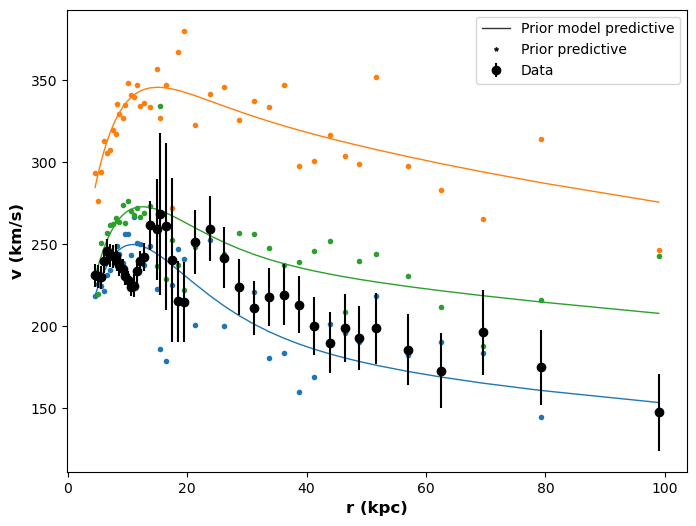

In [52]:
# Plotting
def plot_prior_predictive_with_noise(r, prior_model_predictive, prior_predictive):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot prior model predictive curves
    for i in range(len(prior_model_predictive)):
        ax.plot(r, prior_model_predictive[i], c=f"C{i}", lw=1, label=None)
    
    # Plot prior predictive curves with noise
    for i in range(len(prior_predictive)):
        ax.plot(r, prior_predictive[i], c=f"C{i}", ls="none", marker="o", ms=3, label=None)
    pmp_style = dict(lw=1, alpha=0.8)
    pp_style = dict(ls="none", marker="*", ms=3, alpha=0.8)
    ax.plot([], [], label="Prior model predictive", c="black",**pmp_style)
    ax.plot([], [], label="Prior predictive", c="black",**pp_style)
    ax.errorbar(huang_data["r"],huang_data["v"],yerr=huang_data["v_err"],fmt="ko",label="Data")
    ax.set_xlabel("r (kpc)",fontweight="bold",fontsize="large")
    ax.set_ylabel("v (km/s)",fontweight="bold",fontsize="large")
    ax.legend()
    plt.savefig('./Figures no rings/prior predictive.png')
    plt.show()

# Call the plotting function
plot_prior_predictive_with_noise(r, prior_model_predictive, prior_predictive)


# Defining the posterior

To perform MCMC sampling of the posterior using `emcee`, we need a function which computes the logarithm of the prior

In [16]:
def log_posterior(theta,data):
    logp = log_prior(theta)
    if not np.isfinite(logp):
        return -np.inf
    
    return logp + log_likelihood(theta,data)

# Fitting the data

In [17]:
#combining the measured values into a "data" array
#r, omega_c_obs, omega_c_obs_error, m_b_inner_obs, m_b_inner_error, m_b_outer_obs, m_b_outer_error, m_dc_obs, m_dc_error 
data = (huang_data["r"], huang_data["v"],huang_data["v_err"],0.4e8,0.1e8,0.92e10,0.02e10, 0.9e11, 0.1e11)

#Similarily for the parameters
#r_s, rho_0, M_b_inner,M_b_outer, M_dc

initial_guess = np.array([12.5, 0.4, 0.4e8, 0.92e10, 0.9e11])
variation = 0.1
initial_guess = initial_guess + initial_guess * np.random.uniform(-variation, variation, size=initial_guess.shape)

x = log_posterior(sample_prior(1)[0],data)

import warnings
warnings.filterwarnings('ignore')


## MAP estimate

In [18]:
MAP_result= sp.optimize.minimize(
    fun=lambda theta: -log_posterior(theta=theta, data=data),
    x0=initial_guess,
    method="Nelder-Mead"
)

print(f"Optimisation successful: {MAP_result.success}")

Optimisation successful: True


MAP results: 
 r_s_MAP = 8.169242222569812 
 rho_0_MAP = 0.4145360701428573
 M_b_inner_MAP = 40076369.81020264
 M_b_outer_MAP = 9230550127.601421
 M_dc_MAP = 66574311740.90652


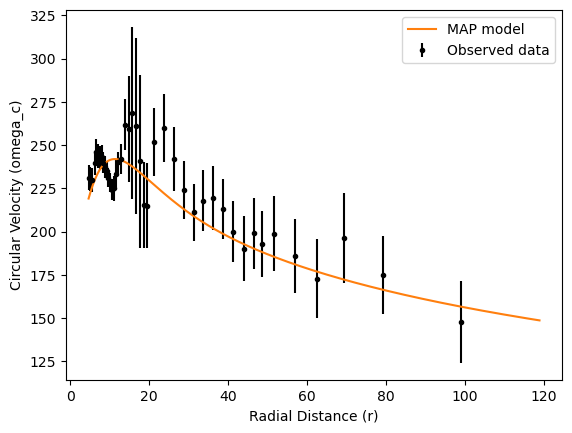

In [19]:
r_s_MAP, rho_0_MAP, M_b_inner_MAP, M_b_outer_MAP, M_dc_MAP = MAP_result.x
print(f"MAP results: \n r_s_MAP = {r_s_MAP} \n rho_0_MAP = {rho_0_MAP}\n M_b_inner_MAP = {M_b_inner_MAP}\n M_b_outer_MAP = {M_b_outer_MAP}\n M_dc_MAP = {M_dc_MAP}")

# Plotting the best-fit model
r_fine = np.linspace(min(data[0]), max(data[0])+20, 500)  # Fine grid for smooth plotting
fig, ax = plt.subplots()
ax.errorbar(data[0], data[1], yerr=data[2], fmt='.k', label='Observed data')
ax.plot(r_fine, omega_c( r_fine,r_s_MAP, rho_0_MAP, M_b_inner_MAP, M_b_outer_MAP, M_dc_MAP), label='MAP model', color='C1')
ax.set_xlabel('Radial Distance (r)')
ax.set_ylabel('Circular Velocity (omega_c)')
ax.legend()

# Set up the `emcee` sampler

The general process to set up an emcee sampler is as follows:
1. Choose the number of dimensions: This corresponds to the number of parameters in your model.
2. Initialize walkers: Walkers are like independent “explorers” that traverse the parameter space.
3. Set initial positions: Start walkers near some reasonable initial guess (the MAP or something close is usually a good choice).

In [20]:
chain_per_walker = np.load("./20000 steps /MCMC main/mcmc_chain.npy")

print("Shape of chain:", chain_per_walker.shape)

n_steps, n_walkers, n_params = chain_per_walker.shape


Shape of chain: (25000, 50, 5)


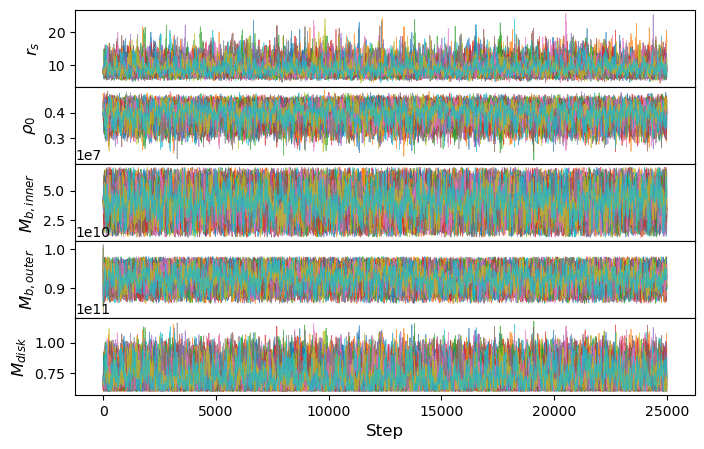

In [21]:
param_names = [r"$r_s$",r"$\rho_0$",r"$M_{b,inner}$",
               r"$M_{b,outer}$",r"$M_{disk}$"]

fig, ax = plt.subplots(len(param_names), 1, sharex=True,figsize=(8,5))
plt.subplots_adjust(hspace=0)

for i, name in enumerate(param_names):
    for j in range(n_walkers):
        ax[i].plot(chain_per_walker[:, j, i], lw=0.5, alpha=0.7, color=f"C{j}")
    ax[i].set_ylabel(name,fontsize="large")

ax[-1].set_xlabel("Step",fontsize="large");

Integrated auto-correlation time
$r_s$: 69.0
$\rho_0$: 68.3
$M_{b,inner}$: 60.2
$M_{b,outer}$: 61.1
$M_{disk}$: 69.4
(726, 50, 5)


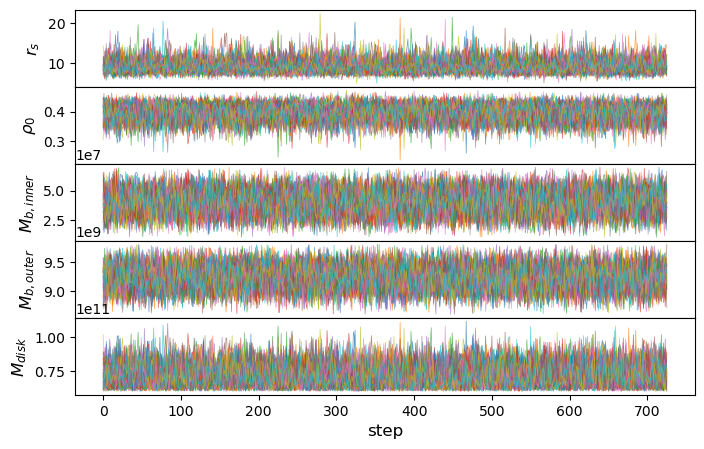

In [22]:
#get autocorrelation times
#in this function, you need to put in the chain as steps,walkers,parameters
tau = emcee.autocorr.integrated_time(chain_per_walker)

print("Integrated auto-correlation time")
for name, iat in zip(param_names, tau):
    print(f"{name}: {iat:.1f}")

burn_in = int(5*max(tau))
thin = int(max(tau)/2)

thinned_chain = chain_per_walker[burn_in::thin,:, :]
print(thinned_chain.shape)
n_steps_thin, n_walkers_thin, n_params_thin = thinned_chain.shape

# Replotting the trace with thinned out chains
fig, ax = plt.subplots(len(param_names), 1, sharex=True,figsize=(8,5))
plt.subplots_adjust(hspace=0)

for i, name in enumerate(param_names):
    for j in range(n_walkers_thin):
        ax[i].plot(thinned_chain[:, j, i], lw=0.5, alpha=0.7, color=f"C{j}")
    ax[i].set_ylabel(name,fontsize="large")

ax[-1].set_xlabel("step",fontsize="large")

plt.savefig('./Figures no rings/trace plot with 10 to 20kpc.png')

In [23]:
mean_values = []
std_values = []
for i, param in enumerate(param_names):
    mean = np.mean(thinned_chain[:,:,i])
    std = np.std(thinned_chain[:,:,i])
    mean_values.append(mean)
    std_values.append(std)
    print(f"{param} = {mean:.4g} ± {std:.2g}")



$r_s$ = 9.043 ± 1.6
$\rho_0$ = 0.3979 ± 0.028
$M_{b,inner}$ = 4.009e+07 ± 1e+07
$M_{b,outer}$ = 9.234e+09 ± 2e+08
$M_{disk}$ = 7.212e+10 ± 7.9e+09


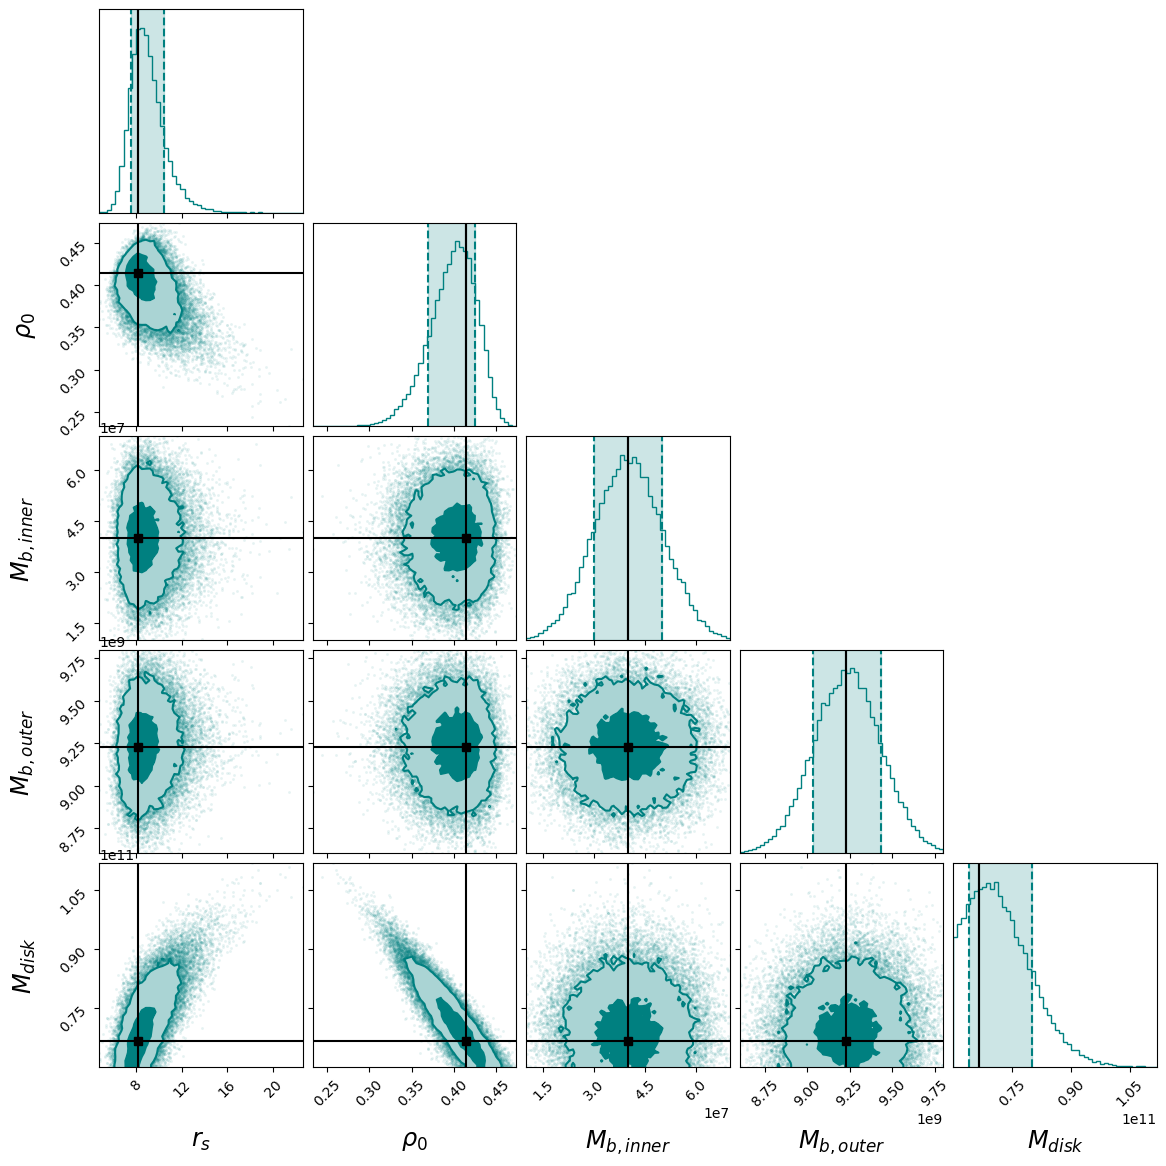

In [24]:
#can use these two lines to create the plot for only specific parameters
#thinned_chain = thinned_chain[:,:,:2]
#param_names = [r"r_s",r"\rho_0"]

fig = plt.figure(figsize=(12,12))
fig = corner.corner(
    thinned_chain.reshape(-1, n_params_thin),
    bins=50,
    labels=param_names,
    label_kwargs={"fontweight":"bold","fontsize":"xx-large"},
    color="teal",
    levels=1-np.exp(-0.5*np.array([1, 2])**2),
    show_titles=False,
    plot_contours=True,
    fill_contours=True,
    truths=MAP_result.x,
    truth_color="k",
#   smooth=True,
    fig=fig,
    quantiles=[0.16, 0.84],
    hist_kwargs={"density":True}
);

#manually adding MAP values on the diagonal, and filling in quantiles
chain_flat = thinned_chain.reshape(-1, n_params_thin)  
for i, ax in enumerate(fig.axes):
    if i % (n_params_thin + 1) == 0:  # Diagonal histograms only
        q16, q84 = np.percentile(chain_flat[:, i // (n_params_thin + 1)], [16, 84])
        x = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
        ax.axvspan(q16, q84, color="teal", alpha=0.2, label="1σ interval")
        ax.axvline(MAP_result.x[i // (n_params_thin + 1)],color="k",label="MAP value")
        
plt.savefig('./Figures no rings/corner plot with 10 to 20kpc.png')

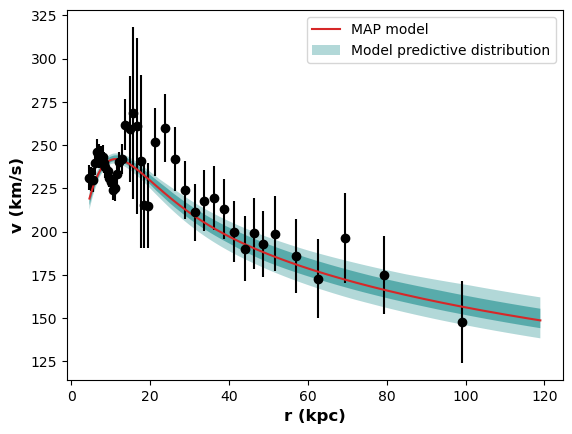

In [25]:
# Choose a small subsample of the chain for plotting purposes
chain_samples = chain_flat[np.random.choice(chain_flat.shape[0], size=200)]

# Evaluate the model at the sample parameters
model_predictive = np.array(
    [omega_c(r_fine,*sample) for sample in chain_samples]
)
model_quantiles = np.quantile(
    model_predictive, q=[0.025, 0.16, 0.84, 0.975], axis=0
)



_, ax = plt.subplots()
ax.errorbar(huang_data["r"],huang_data["v"],huang_data["v_err"],fmt="ko")

ax.plot(r_fine,omega_c(r_fine,r_s_MAP, rho_0_MAP, M_b_inner_MAP, M_b_outer_MAP, M_dc_MAP), 
        c="C3", label="MAP model")
ax.fill_between(r_fine, model_quantiles[0], model_quantiles[-1], alpha=0.3, facecolor="teal",
                label="Model predictive distribution")
ax.fill_between(r_fine, model_quantiles[1], model_quantiles[-2], alpha=0.5, facecolor="teal")
ax.legend()
ax.set_xlabel("r (kpc)",fontweight="bold",fontsize="large")
ax.set_ylabel("v (km/s)",fontweight="bold",fontsize="large")

plt.savefig('./Figures no rings/fit plot with 10 to 20kpc.png')

# 10 to 20kpc removed

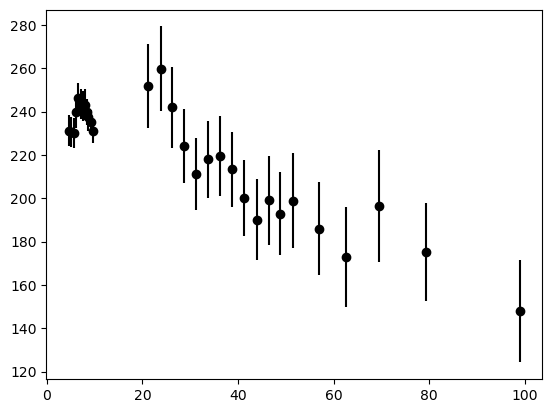

In [42]:
huang_data_removed = huang_data[(huang_data["r"] < 10) | (huang_data["r"] > 20)]

plt.errorbar(huang_data_removed["r"],huang_data_removed["v"],huang_data_removed["v_err"],fmt="ko")

data_removed = (huang_data_removed["r"], huang_data_removed["v"],huang_data_removed["v_err"],0.4e8,0.1e8,0.92e10,0.02e10, 0.9e11, 0.1e11)

## MAP estimate

In [45]:
initial_guess = np.array([12.5, 0.4, 0.4e8, 0.92e10, 0.9e11]) #same initial values just for the sake of comparision
variation = 0.1
initial_guess = initial_guess + initial_guess * np.random.uniform(-variation, variation, size=initial_guess.shape)

x = log_posterior(sample_prior(1)[0],data_removed)

import warnings
warnings.filterwarnings('ignore')


In [46]:
MAP_result_removed= sp.optimize.minimize(
    fun=lambda theta: -log_posterior(theta=theta, data=data_removed),
    x0=initial_guess,
    method="Nelder-Mead"
)

print(f"Optimisation successful: {MAP_result_removed.success}")

Optimisation successful: True


MAP results: 
 r_s_MAP = 9.469732194448463 
 rho_0_MAP = 0.408640715466398
 M_b_inner_MAP = 40047157.755366996
 M_b_outer_MAP = 9218862042.511982
 M_dc_MAP = 78556033193.42606


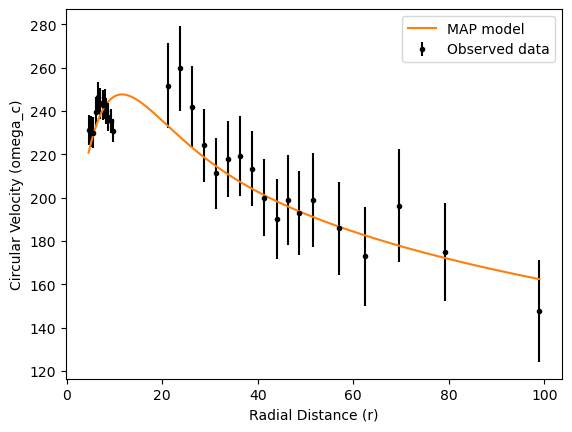

In [47]:
r_s_MAP_removed, rho_0_MAP_removed, M_b_inner_MAP_removed, M_b_outer_MAP_removed, M_dc_MAP_removed = MAP_result_removed.x
print(f"MAP results: \n r_s_MAP = {r_s_MAP_removed} \n rho_0_MAP = {rho_0_MAP_removed}\n M_b_inner_MAP = {M_b_inner_MAP_removed}\n M_b_outer_MAP = {M_b_outer_MAP_removed}\n M_dc_MAP = {M_dc_MAP_removed}")

# Plotting the best-fit model
r_fine = np.linspace(min(data_removed[0]), max(data_removed[0]), 500)  # Fine grid for smooth plotting
fig, ax = plt.subplots()
ax.errorbar(data_removed[0], data_removed[1], yerr=data_removed[2], fmt='.k', label='Observed data')
ax.plot(r_fine, omega_c(r_fine,r_s_MAP_removed, rho_0_MAP_removed, M_b_inner_MAP_removed, M_b_outer_MAP_removed, M_dc_MAP_removed), label='MAP model', color='C1')
ax.set_xlabel('Radial Distance (r)')
ax.set_ylabel('Circular Velocity (omega_c)')
ax.legend()

## MCMC analysis

In [48]:
chain_per_walker_removed = np.load("./20000 steps /MCMC peaks removed/mcmc_chain_removed.npy")

print("Shape of chain:", chain_per_walker_removed.shape)

n_steps_removed, n_walkers_removed, n_params_removed = chain_per_walker_removed.shape

Shape of chain: (25000, 50, 5)


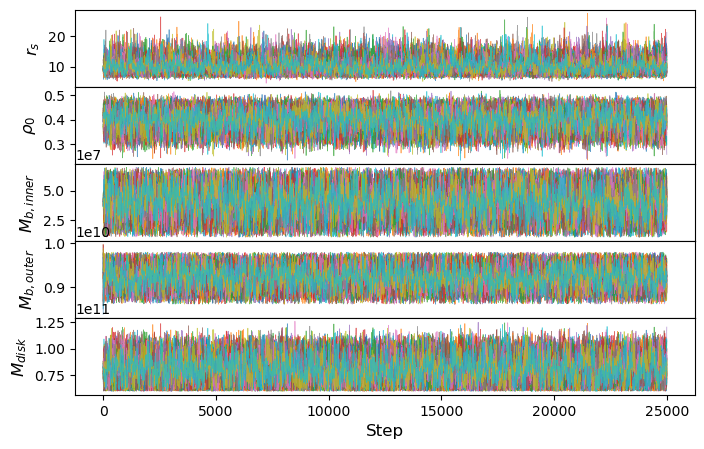

In [31]:
param_names = [r"$r_s$",r"$\rho_0$",r"$M_{b,inner}$",
               r"$M_{b,outer}$",r"$M_{disk}$"]

fig, ax = plt.subplots(len(param_names), 1, sharex=True,figsize=(8,5))
plt.subplots_adjust(hspace=0)

for i, name in enumerate(param_names):
    for j in range(n_walkers_removed):
        ax[i].plot(chain_per_walker_removed[:, j, i], lw=0.5, alpha=0.7, color=f"C{j}")
    ax[i].set_ylabel(name,fontsize="large")

ax[-1].set_xlabel("Step",fontsize="large");

Integrated auto-correlation time
$r_s$: 67.0
$\rho_0$: 62.9
$M_{b,inner}$: 60.7
$M_{b,outer}$: 57.5
$M_{disk}$: 64.0
(748, 50, 5)


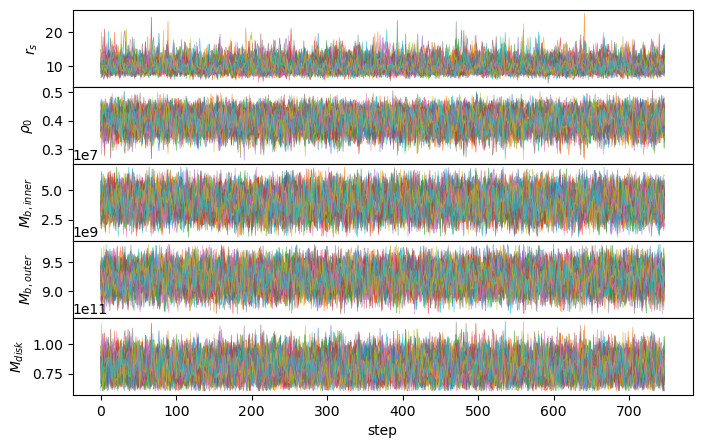

In [32]:
#get autocorrelation times
#in this function, you need to put in the chain as steps,walkers,parameters
tau_removed = emcee.autocorr.integrated_time(chain_per_walker_removed)

print("Integrated auto-correlation time")
for name, iat in zip(param_names, tau_removed):
    print(f"{name}: {iat:.1f}")

burn_in_removed = int(5*max(tau_removed))
thin_removed = int(max(tau_removed)/2)

thinned_chain_removed = chain_per_walker_removed[burn_in_removed::thin_removed,:, :]
print(thinned_chain_removed.shape)
n_steps_thin_removed, n_walkers_thin_removed, n_params_thin_removed = thinned_chain_removed.shape

# Replotting the trace with thinned out chains
fig, ax = plt.subplots(len(param_names), 1, sharex=True,figsize=(8,5))
plt.subplots_adjust(hspace=0)

for i, name in enumerate(param_names):
    for j in range(n_walkers_thin_removed):
        ax[i].plot(thinned_chain_removed[:, j, i], lw=0.5, alpha=0.7, color=f"C{j}")
    ax[i].set_ylabel(name)

ax[-1].set_xlabel("step")

plt.savefig('./Figures no rings/trace plot without 10 to 20kpc.png')

In [33]:
mean_values_removed = []
std_values_removed = []
for i, param in enumerate(param_names):
    mean = np.mean(thinned_chain_removed[:,:,i])
    std = np.std(thinned_chain_removed[:,:,i])
    mean_values_removed.append(mean)
    std_values_removed.append(std)
    print(f"{param} = {mean:.4g} ± {std:.2g}")



$r_s$ = 10.13 ± 1.8
$\rho_0$ = 0.4003 ± 0.034
$M_{b,inner}$ = 3.994e+07 ± 9.9e+06
$M_{b,outer}$ = 9.222e+09 ± 2e+08
$M_{disk}$ = 8.114e+10 ± 9.6e+09


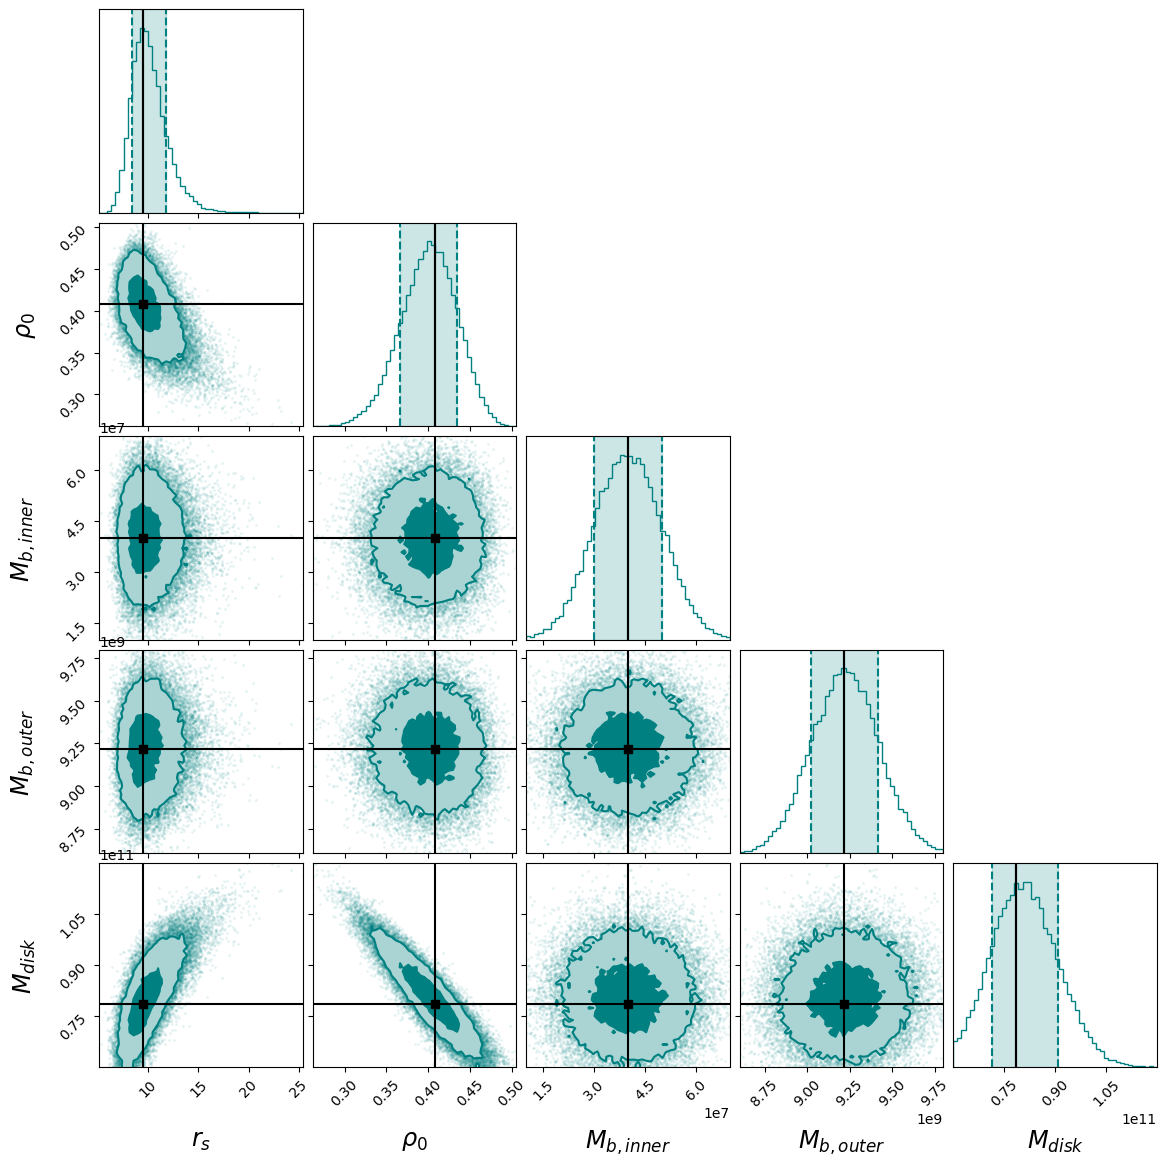

In [49]:
#can use these two lines to create the plot for only specific parameters
#thinned_chain = thinned_chain[:,:,:2]
#param_names = [r"r_s",r"\rho_0"]

fig = plt.figure(figsize=(12,12))
fig = corner.corner(
    thinned_chain_removed.reshape(-1, n_params_thin_removed),
    bins=50,
    labels=param_names,
    label_kwargs={"fontweight":"bold","fontsize":"xx-large"},
    color="teal",
    levels=1-np.exp(-0.5*np.array([1, 2])**2),
    show_titles=False,
    plot_contours=True,
    fill_contours=True,
    truths=MAP_result_removed.x,
    truth_color="k",
#   smooth=True,
    fig=fig,
    quantiles=[0.16, 0.84],
    hist_kwargs={"density":True}
);

#manually adding MAP values on the diagonal, and filling in quantiles
chain_flat_removed = thinned_chain_removed.reshape(-1, n_params_thin_removed)  
for i, ax in enumerate(fig.axes):
    if i % (n_params_thin_removed + 1) == 0:  # Diagonal histograms only
        q16_removed, q84_removed = np.percentile(chain_flat_removed[:, i // (n_params_thin_removed + 1)], [16, 84])
        x = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
        ax.axvspan(q16_removed, q84_removed, color="teal", alpha=0.2, label="1σ interval")
        ax.axvline(MAP_result_removed.x[i // (n_params_thin_removed + 1)],color="k",label="MAP value")
        
plt.savefig('./Figures no rings/corner plot without 10 to 20kpc.png')

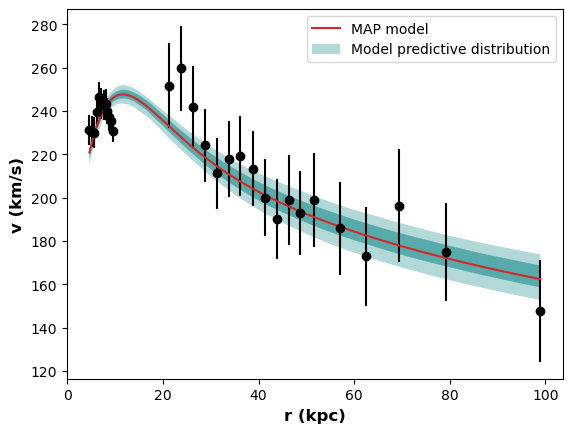

In [50]:
# Choose a small subsample of the chain for plotting purposes
chain_samples_removed = chain_flat_removed[np.random.choice(chain_flat.shape[0], size=200)]

# Evaluate the model at the sample parameters
model_predictive_removed = np.array(
    [omega_c(r_fine,*sample) for sample in chain_samples_removed]
)
model_quantiles_removed = np.quantile(
    model_predictive_removed, q=[0.025, 0.16, 0.84, 0.975], axis=0
)



_, ax = plt.subplots()
ax.errorbar(huang_data_removed["r"],huang_data_removed["v"],huang_data_removed["v_err"],fmt="ko")

ax.plot(r_fine,omega_c(r_fine,r_s_MAP_removed, rho_0_MAP_removed, M_b_inner_MAP_removed, M_b_outer_MAP_removed, M_dc_MAP_removed), 
        c="C3", label="MAP model")
ax.fill_between(r_fine, model_quantiles_removed[0], model_quantiles_removed[-1], alpha=0.3, facecolor="teal",
                label="Model predictive distribution")
ax.fill_between(r_fine, model_quantiles_removed[1], model_quantiles_removed[-2], alpha=0.5, facecolor="teal")
ax.legend()
ax.set_xlabel("r (kpc)",fontweight="bold",fontsize="large")
ax.set_ylabel("v (km/s)",fontweight="bold",fontsize="large")

plt.savefig('./Figures no rings/fit plot without 10 to 20kpc.png')

## Comparing both on corner plots

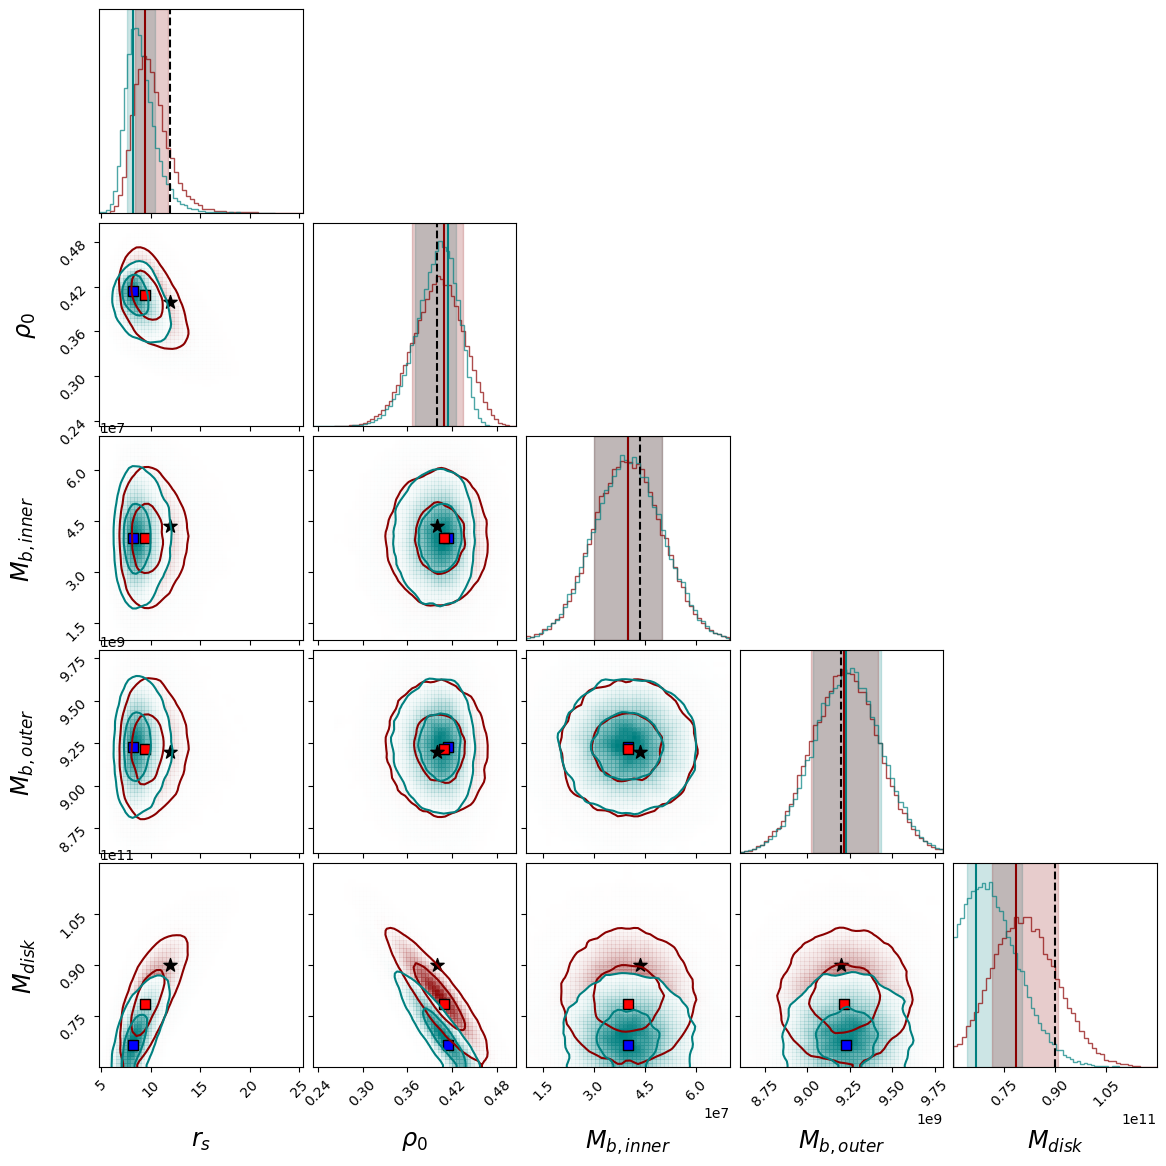

In [51]:
#can use these two lines to create the plot for only specific parameters
#thinned_chain = thinned_chain[:,:,:2]
#param_names = [r"r_s",r"\rho_0"]

literature_values = [12,0.4,0.436e8,0.92e10,0.9e11]

fig = plt.figure(figsize=(12,12))

fig = corner.corner(
    thinned_chain_removed.reshape(-1, n_params_thin_removed),
    bins=50,
    labels=param_names,
    label_kwargs={"fontweight":"bold","fontsize":"xx-large"},
    color="darkred",
    plot_datapoints=False,
    levels=1-np.exp(-0.5*np.array([1, 2])**2),
    show_titles=False,
    plot_contours=True,
    fill_contours=False,
    smooth=True,
    fig=fig,
    hist_kwargs={"density":True,"alpha":0.7},
);

fig = corner.corner(
    thinned_chain.reshape(-1, n_params_thin),
    bins=50,
    labels=param_names,
    label_kwargs={"fontweight":"bold","fontsize":"xx-large"},
    color="teal",
    levels=1-np.exp(-0.5*np.array([1, 2])**2),
    show_titles=False,
    plot_contours=True,
    fill_contours=False,
    plot_datapoints=False,
    smooth=True,
    fig=fig,
    hist_kwargs={"density":True,"alpha":0.7},
);

#manually adding MAP values on the diagonal, and filling in quantiles
chain_flat = thinned_chain.reshape(-1, n_params_thin)  
for i, ax in enumerate(fig.axes):
    if i % (n_params_thin + 1) == 0:  # Diagonal histograms only
        q16, q84 = np.percentile(chain_flat[:, i // (n_params_thin + 1)], [16, 84])
        x = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
        ax.axvspan(q16, q84, color="teal", alpha=0.2, label="1σ interval")
        ax.axvline(MAP_result.x[i // (n_params_thin + 1)],color="teal",label="MAP value")
        ax.axvline(literature_values[i // (n_params_thin + 1)],color="black",linestyle="--")

chain_flat_removed = thinned_chain_removed.reshape(-1, n_params_thin_removed)  
for i, ax in enumerate(fig.axes):
    if i % (n_params_thin_removed + 1) == 0:  # Diagonal histograms only
        q16_removed, q84_removed = np.percentile(chain_flat_removed[:, i // (n_params_thin_removed + 1)], [16, 84])
        x = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
        ax.axvspan(q16_removed, q84_removed, color="darkred", alpha=0.2, label="1σ interval")
        ax.axvline(MAP_result_removed.x[i // (n_params_thin_removed + 1)],color="darkred",label="MAP value")

# Adding MAP values as scatter points on 2D histograms (off-diagonal subplots)
for i, ax in enumerate(fig.axes):
    row = i // n_params_thin
    col = i % n_params_thin
    if row > col:  
        ax.scatter(MAP_result.x[col], MAP_result.x[row], 
                   color="blue", edgecolor="black", s=50, marker="s",label="MAP value")
        
        ax.scatter(MAP_result_removed.x[col], MAP_result_removed.x[row], 
                   color="red", edgecolor="black", s=50, marker="s",label="MAP value (removed)")

        ax.scatter(literature_values[col], literature_values[row], color="black",marker="*",s=100, label="Literature")


plt.savefig('./Figures no rings/combined corner plot.png')        

# Model checking

## Bayesian evidence

In [37]:
def prior_transform_model(u):
    x = np.array([r_s_prior.ppf(u[0]),
                  rho_0_prior.ppf(u[1]),
                  M_b_inner_prior.ppf(u[2]),
                  M_b_outer_prior.ppf(u[3]),
                  M_dc_prior.ppf(u[4])
                 ])
    return x

In [38]:
#def log_likelihood_wrapper(theta):
#    return log_likelihood(theta,data=data)

#sampler = dynesty.NestedSampler(loglikelihood=log_likelihood_wrapper,
#                               prior_transform=prior_transform_model,
#                               ndim=n_params,
#                               nlive=500)

#sampler.run_nested(print_progress=True)
#sampler.results.summary()

In [39]:
#with open("./evidence_samples_no_rings.pkl","wb") as f:
#    pickle.dump(sampler.results,f)

## Chi-squared with MAP values

In [40]:
def chi_squared_sampling(theta,x=huang_data["r"],
                         v=huang_data["v"],
                         verr=huang_data["v_err"]):
    r_s, rho_0, M_b_inner, M_b_outer, M_dc = theta
    mu = omega_c(x,r_s, rho_0, M_b_inner, M_b_outer, M_dc)
    return np.sum((v - mu)**2/verr**2)

chi_squared_MAP = chi_squared_sampling(theta=(r_s_MAP, rho_0_MAP, M_b_inner_MAP, M_b_outer_MAP, M_dc_MAP))

n_data = len(huang_data["r"])
n_param = 5

PTE = sp.stats.chi2(df=n_data - n_param).sf(chi_squared_MAP)

print(f"No rings: χ²={chi_squared_MAP:.1f}, "
      f"ndof={n_data}-{n_param}, PTE={PTE:.3f}")


No rings: χ²=55.1, ndof=43-5, PTE=0.036


## DIC

In [41]:
def DIC(theta_star, theta_samples):
    # Compute log likelihood at theta_star and the samples theta_i
    log_likelihood_star = log_likelihood(theta_star,data)
    log_likelihood_samples = np.array(
        [log_likelihood(theta,data) for theta in theta_samples]
    )
    p_D = 2*(log_likelihood_star - np.mean(log_likelihood_samples))
    p_V = 2*np.var(log_likelihood_samples)
    return -2*(log_likelihood_star - p_D), p_D, p_V

DIC_lin, p_D_lin, p_V_lin = DIC(
    theta_star=(r_s_MAP, rho_0_MAP, M_b_inner_MAP, M_b_outer_MAP, M_dc_MAP),
    theta_samples=thinned_chain.reshape((-1, thinned_chain.shape[-1])),
)

print(f"{DIC_lin:.1f}, p_D = {p_D_lin:.1f}, p_V = {p_V_lin:.1f}")


-6326.6, p_D = 4.9, p_V = 4.9
